# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression and energy budget - AMET (ERAI) & OMET (ORAS4) ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.09.24 ** <br>
** Last Update  : 2018.09.24 ** <br>
Description  : This script serves to investigate the compensation between energy transport in the atmosphere and ocean. It works with AMET and OMET estimated from ERA-Interim and ORAS4. Lead/lag regressions are performed to check the compensation.<br>
Return Values : jpeg <br>
Caveat : The AMET is computed as the residual of net flux at TOA & surface. <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg] 
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/MET_Feedback/figures/subFigures'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                 'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                       'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 3D fields [year, month, lat]
    # since OMET is from 20N - 90N, AMET is from 90N to 20N, we have to reverse it
    # for interpolation, x should be monotonically increasing
    AMET_div_ERAI = dataset_ERAI_AMET.variables['E_total_int'][:,:,::-1]/1000 # from Tera Watt to Peta Watt
    # 4D fields [year, month, level, lat]
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI + rad_long_surf_ERAI + SFlux_sensible_ERAI + SFlux_latent_ERAI
    net_flux_toa_ERAI = rad_short_toa_ERAI + rad_long_toa_ERAI
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    # 3D fields [year, month, lat]
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    year_ERAI = dataset_ERAI_AMET.variables['year']
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][::-1]
    latitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]    
    # area weighted surface flux
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float) # unit W
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]* dx[i] * dy / 1E+12

*********************** extract variables *************************


In [4]:
    print ('Compute AMET as the residuals of net flux at TOA & surface.')
    # take the zonal mean of flux
    net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,3) / 1000 # PW
    net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_ERAI = np.zeros(net_flux_surf_ERAI_int.shape)
    for i in np.arange(len(latitude_fields_ERAI)-1):
        AMET_res_ERAI[:,:,i] = -(np.sum(net_flux_toa_ERAI_int[:,:,0:i+1],2) -
                                 np.sum(net_flux_surf_ERAI_int[:,:,0:i+1],2))
    print (AMET_res_ERAI.shape)
    # invert the latitudinal coordinate
    AMET_res_ERAI = AMET_res_ERAI[:,:,0:95]
    AMET_res_ERAI_inv = AMET_res_ERAI[:,:,::-1]
    print (AMET_res_ERAI_inv.shape)

Compute AMET as the residuals of net flux at TOA & surface.
(38, 12, 241)
(38, 12, 95)


Perform interpolation as AMET and OMET has different resoltion in terms of the latitudes.

In [5]:
    print ('*******************  interpolation for regression   **********************')
    # interpolate OMET on the latitude of AMET
    # ORAS4 - ERAI
    # glole
    OMET_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    # atlantic
    OMET_atl_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    # an easy check for the interpolation
    #plt.plot(latitude_AMET_ERAI,OMET_atl_ORAS4_interp_ERAI[2,11,:],linewidth=6.0)
    #plt.plot(latitude_OMET_ORAS4,OMET_atl_int_ORAS4[2,11,:])

*******************  interpolation for regression   **********************


*******************  postprocess with statistical tool  *********************
***********!@#$%^&*  Lead/ Lag regression of ORAS4 - ERAI  !@#$%^&***********
======================   AMET + 0 & OMET + atl + 0   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
Create contour plot of correlation coefficient.


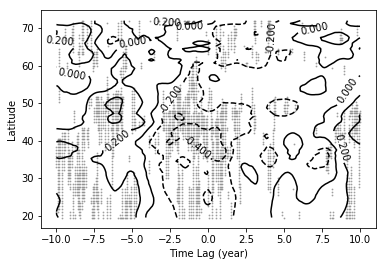

In [9]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&*  Lead/ Lag regression of ORAS4 - ERAI  !@#$%^&***********')
    print ('======================   AMET + 0 & OMET + atl + 0   ========================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_res_ERAI_inv)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=12, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=12, obj='detrend')
    #k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
    #                                                 stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_OMET_ORAS4._detrend, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[:71], r[:,:71], lag, p_real[:,:71],
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_atl_0_omet_annual.png'),
                                         ttest=True)